## Do Whales Move the Market

### Environment and API Key Setup
Set up environment variables and load API keys for data access.

In [2]:
# ### Environment and API Key Setup
# Set up environment variables and load API keys for data access.
import os
import requests
import pandas as pd
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()
COINGECK_API = os.getenv('GECKO_API')  # CoinGecko API key (if needed)
#ETHERSCAN_API_KEY = os.getenv('ETHERSCAN_API')  # Etherscan API key (if needed)
API_KEY = os.getenv('DUNE_CUSTOM_API')  # Dune custom endpoint API key


ModuleNotFoundError: No module named 'requests'

### Fetch Whale Transaction Data
Retrieve Ethereum whale transaction data using Dune custom endpoint.

In [ ]:
# ### Fetch Whale Transaction Data
# Retrieve Ethereum whale transaction data using Dune custom endpoint.
from dune_client.client import DuneClient
import pandas as pd

# Initialize Dune client
dune = DuneClient(API_KEY)

# Fetch whale transaction data
response = dune.get_custom_endpoint_result(
    "firstbml",
    "ethereum-whale-transactions",
    limit=100
)

# Convert response to DataFrame
df = pd.DataFrame(response.get_rows())

# Format whale_volume_usd as currency if present
if 'whale_volume_usd' in df.columns:
    df['whale_volume_usd'] = df['whale_volume_usd'].astype(float).map(lambda x: f"${x:,.2f}")

# Set 'day' as the index if present
if 'day' in df.columns:
    df.set_index('day', inplace=True)

print(df.head(100))

                             whale_transfer_count    whale_volume_usd
day                                                                  
2025-08-07 00:00:00.000 UTC                  4040   $3,846,522,796.69
2025-08-06 00:00:00.000 UTC                  6408  $11,240,328,895.71
2025-08-05 00:00:00.000 UTC                  7163  $12,013,744,506.35
2025-08-04 00:00:00.000 UTC                  8027  $14,924,857,584.20
2025-08-03 00:00:00.000 UTC                  6541   $7,100,483,296.62
...                                           ...                 ...
2025-05-13 00:00:00.000 UTC                  8556   $8,363,297,586.85
2025-05-12 00:00:00.000 UTC                  8528   $8,263,243,399.90
2025-05-11 00:00:00.000 UTC                  5586   $4,806,501,373.86
2025-05-10 00:00:00.000 UTC                  6795   $5,381,494,809.89
2025-05-09 00:00:00.000 UTC                  4123   $4,787,636,174.89

[91 rows x 2 columns]


### Fetche the daily price of Ethereum (ETH) in USD for the last 30 days from the CoinGecko API

In [ ]:
# ### Fetch Ethereum Price Data
# Get daily Ethereum price data for the last 30 days from CoinGecko.
import requests
import pandas as pd

# Define CoinGecko endpoint and parameters
coingecko_url = "https://api.coingecko.com/api/v3/coins/ethereum/market_chart"
params = {
    "vs_currency": "usd",
    "days": "91",
    "interval": "daily"
}

# Fetch price data
cg_response = requests.get(coingecko_url, params=params)
cg_data = cg_response.json()

# Convert to DataFrame
eth_prices = pd.DataFrame(cg_data['prices'], columns=['timestamp', 'eth_price'])
eth_prices['timestamp'] = pd.to_datetime(eth_prices['timestamp'], unit='ms')
eth_prices['date'] = eth_prices['timestamp'].dt.date
eth_prices = eth_prices[['date', 'eth_price']]


### Aggregate Whale Volume by Day
Process and aggregate whale transaction volume to daily totals.

In [ ]:
# Aggregate whale volume by day
# Handle both string and float types
colname = None
if 'total_whale_volume_usd' in df.columns:
    colname = 'total_whale_volume_usd'
elif 'whale_volume_usd' in df.columns:
    colname = 'whale_volume_usd'

# Use the correct date column for grouping
date_col = None
if 'date' in df.columns:
    date_col = 'date'
elif 'day' in df.columns:
    date_col = 'day'
elif df.index.name in ['date', 'day']:
    df = df.reset_index()
    if 'date' in df.columns:
        date_col = 'date'
    elif 'day' in df.columns:
        date_col = 'day'

if colname and date_col:
    if df[colname].dtype == 'O':
        # If object, clean and convert
        daily_whale_volume = df.groupby(date_col)[colname].apply(
            lambda x: pd.to_numeric(x.str.replace(r'[$,]', '', regex=True), errors='coerce').sum()
        ).reset_index()
    else:
        # If already numeric
        daily_whale_volume = df.groupby(date_col)[colname].sum().reset_index()
    daily_whale_volume.columns = [date_col, 'whale_volume_usd']  # Rename columns
    # Format whale_volume_usd as currency
    daily_whale_volume['whale_volume_usd'] = daily_whale_volume['whale_volume_usd'].map(lambda x: f"${x:,.2f}")
    print(daily_whale_volume.head(91))  # Display first 20 rows
else:
    print("No whale volume column or date column found in DataFrame")

                            day    whale_volume_usd
0   2025-05-09 00:00:00.000 UTC   $4,787,636,174.89
1   2025-05-10 00:00:00.000 UTC   $5,381,494,809.89
2   2025-05-11 00:00:00.000 UTC   $4,806,501,373.86
3   2025-05-12 00:00:00.000 UTC   $8,263,243,399.90
4   2025-05-13 00:00:00.000 UTC   $8,363,297,586.85
..                          ...                 ...
86  2025-08-03 00:00:00.000 UTC   $7,100,483,296.62
87  2025-08-04 00:00:00.000 UTC  $14,924,857,584.20
88  2025-08-05 00:00:00.000 UTC  $12,013,744,506.35
89  2025-08-06 00:00:00.000 UTC  $11,240,328,895.71
90  2025-08-07 00:00:00.000 UTC   $3,846,522,796.69

[91 rows x 2 columns]


### Format and Display Merged Data
Format whale volume and ETH price as currency and display sample merged data.

In [ ]:
# Step 1: Make sure both date columns are of type datetime.date
eth_prices['date'] = pd.to_datetime(eth_prices['date']).dt.date
daily_whale_volume['day'] = pd.to_datetime(daily_whale_volume['day']).dt.date

# Step 2: Merge on date
merged = pd.merge(
    eth_prices,
    daily_whale_volume,
    left_on='date',
    right_on='day',
    how='inner'
)

# Step 3: Convert '$' string columns to float
merged['whale_volume_usd_num'] = pd.to_numeric(merged['whale_volume_usd'].replace(r'[$,]', '', regex=True), errors='coerce')
merged['eth_price_num'] = pd.to_numeric(merged['eth_price'].replace(r'[$,]', '', regex=True), errors='coerce')


print(merged[['date', 'whale_volume_usd', 'eth_price']].head(91))  # Display first 30 rows

          date    whale_volume_usd    eth_price
0   2025-05-10   $5,381,494,809.89  2341.407963
1   2025-05-11   $4,806,501,373.86  2583.682905
2   2025-05-12   $8,263,243,399.90  2507.469311
3   2025-05-13   $8,363,297,586.85  2492.426391
4   2025-05-14   $8,516,583,920.03  2676.639163
..         ...                 ...          ...
85  2025-08-03   $7,100,483,296.62  3397.485548
86  2025-08-04  $14,924,857,584.20  3497.573128
87  2025-08-05  $12,013,744,506.35  3715.709015
88  2025-08-06  $11,240,328,895.71  3612.442432
89  2025-08-07   $3,846,522,796.69  3684.045920

[90 rows x 3 columns]


### Bar chart for whale volume and line chart for ETH price on the same plot

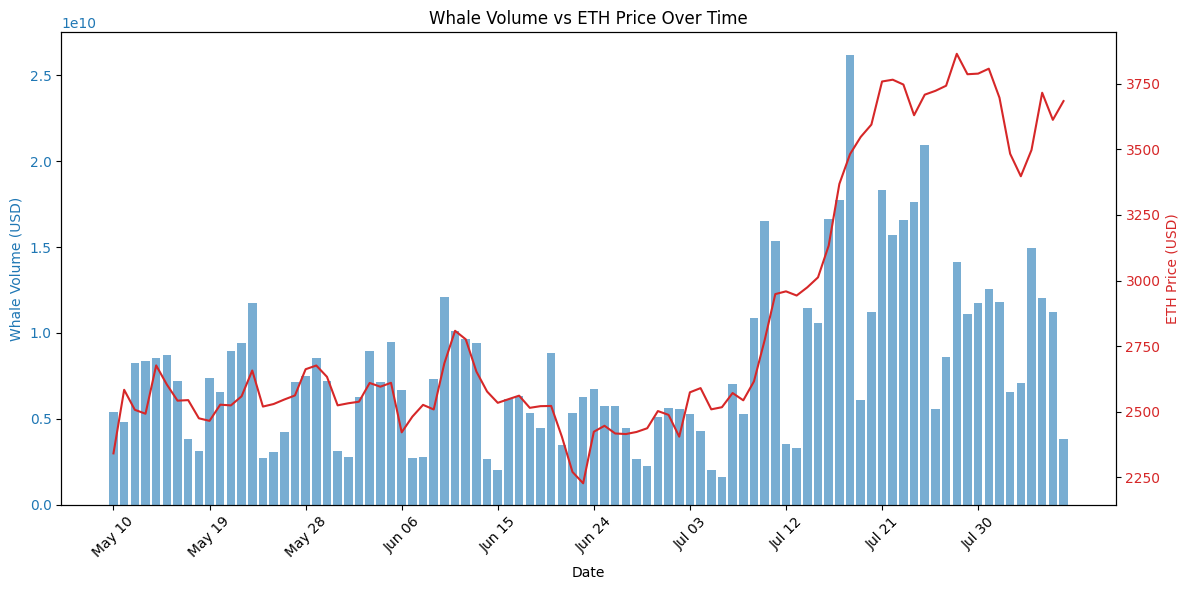

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Step 4: Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Format x-axis date ticks
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=7))  # Show one tick every 7 days
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))    # Format as 'Aug 01'


# Bar chart for whale volume (left y-axis)
ax1.bar(merged['date'], merged['whale_volume_usd_num'], color='tab:blue', alpha=0.6, label='Whale Volume (USD)')
ax1.set_ylabel('Whale Volume (USD)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xlabel('Date')
ax1.set_xticks(merged['date'][::max(len(merged)//10,1)])  # reduce ticks
ax1.tick_params(axis='x', rotation=45)

# Line chart for ETH price (right y-axis)
ax2 = ax1.twinx()
ax2.plot(merged['date'], merged['eth_price_num'], color='tab:red', label='ETH Price')
ax2.set_ylabel('ETH Price (USD)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and legend
plt.title('Whale Volume vs ETH Price Over Time')
fig.tight_layout()
plt.show()


### Correlation Analysis
Calculate and print the correlation between whale volume and ETH price.

In [ ]:
# Ensure numeric columns are clean and available
merged['whale_volume_usd_num'] = pd.to_numeric(
    merged['whale_volume_usd'].replace(r'[$,]', '', regex=True),
    errors='coerce'
)
merged['eth_price_num'] = pd.to_numeric(
    merged['eth_price'].replace(r'[$,]', '', regex=True),
    errors='coerce'
)

# Drop rows with NaN values in either column (optional but recommended)
cleaned = merged.dropna(subset=['whale_volume_usd_num', 'eth_price_num'])

# Calculate correlation
correlation = cleaned['whale_volume_usd_num'].corr(cleaned['eth_price_num'])

# Print result
print(f"Correlation between ETH price and whale volume: {correlation:.4f}")


Correlation between ETH price and whale volume: 0.6292


### Visualization
Plot daily whale volume and ETH price with dual y-axes for trend analysis.

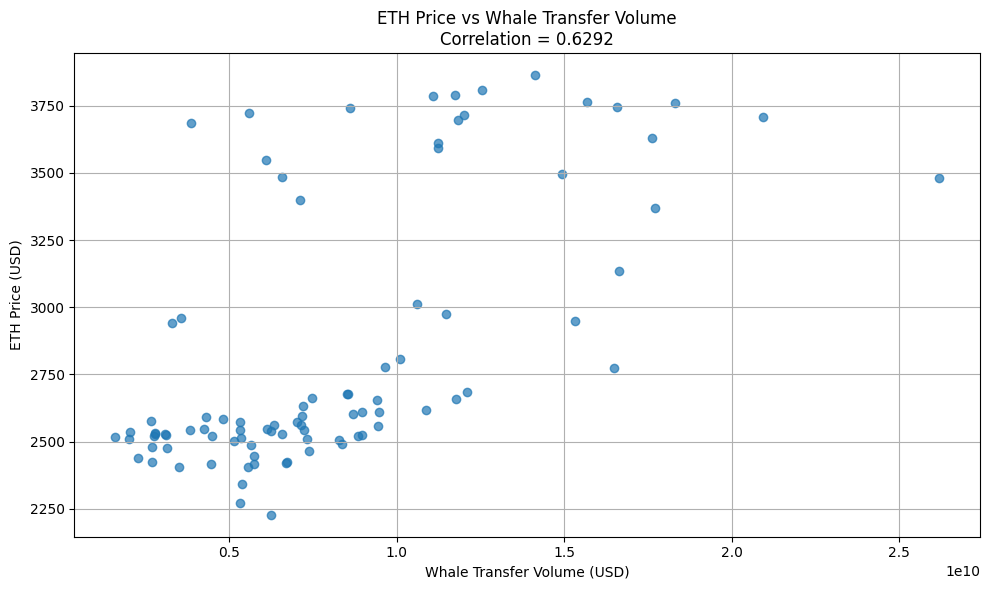

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(cleaned['whale_volume_usd_num'], cleaned['eth_price_num'], alpha=0.7)
plt.title(f'ETH Price vs Whale Transfer Volume\nCorrelation = {correlation:.4f}')
plt.xlabel('Whale Transfer Volume (USD)')
plt.ylabel('ETH Price (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()